# Fitness MCMC Documentation Notebook

In [8]:
#Standard Imports
import numpy as np
import pymc3 as pm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

In [9]:
#Imports from fitness mcmc package 
import fitness_mcmc
import fitness_mcmc.data_io as io 
import fitness_mcmc.fitness_mcmc as m

### Looking at the data

The function `load_data` in `data_io.py` returns a pandas dataframe of the raw data (i.e. `data`), a numpy array of time generations (i.e. `time`), and a numpy array of arrays of ordered frequencies (i.e. `ordered_frequencies`) where the order is determined by the number of counts. 

In [10]:
"""
Loading data and looking at the first 40 ordered genotypes. 
"""
data, time, ordered_counts = io.load_data("filtered_counts_ypd_temp_30.txt", return_ordered = True)
print(ordered_counts.astype("int"))
print(data)

[[[ 52451]
  [ 50294]
  [151978]
  [177477]
  [216679]]

 [[ 15607]
  [ 15010]
  [ 43410]
  [ 48756]
  [ 58213]]

 [[ 16176]
  [ 13409]
  [ 36022]
  [ 33824]
  [ 42689]]

 ...

 [[     8]
  [     1]
  [     0]
  [     0]
  [     0]]

 [[     9]
  [     0]
  [     0]
  [     0]
  [     0]]

 [[     4]
  [     1]
  [     0]
  [     0]
  [     0]]]
                                    BC      5     10      25      40      45
668  AGAGTGACTTTCGGAC_TACGAGTAATCGCAAG  52451  50294  151978  177477  216679
495  TAGATCAACACAAAGT_AGCTGTACACCCTGCA  15607  15010   43410   48756   58213
617  GTTTGGCGAAACTGCA_TCTGGTCAACTGCAAA  16176  13409   36022   33824   42689
686  CCAACCCGAATAAATC_ACCATAGGGATAACTG  22295  19714   24746   22596   19846
218  CGATCAAACGTAGAAA_AGAAAGATGGTGGAAT  17669  13734   22203   22902   31581
..                                 ...    ...    ...     ...     ...     ...
21   GGTTCTACGATTGTGA_AAGGTTATGAATCATA     13      4       0       0       0
375  CAATTAGTCGCTATAG_AGCACAATTGAGGA

The first row `5, 10, 25, 40, 45` shows the generations where genotypes are sampled. The values under the generation represent counts - the number of each genotype alive. The frequency metadata is calculated by normalizing the counts per generation sample and then they are ordered by genotype with the most total counts across all generations. That is what ordered frequencies represents. 

ValueError: x and y must have same first dimension, but have shapes (5,) and (1, 5, 723)

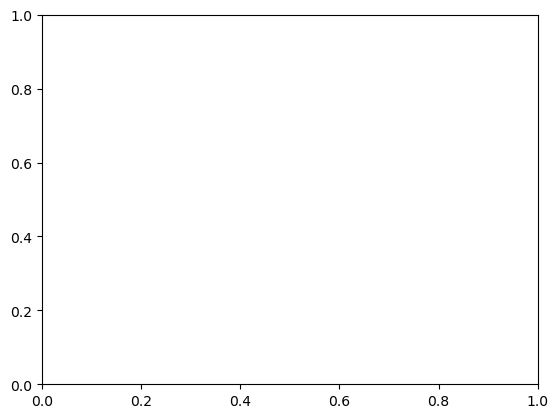

In [11]:
ordered_frequencies = ordered_counts / np.sum(ordered_counts, axis = 0)

plt.plot([5,10,25,40,45], ordered_frequencies.T);
plt.xlabel('Time (generations)')
plt.ylabel('Frequency')
plt.show()

A visual Plot of the data below. Each line indicates a lineage or a genotype (e.g. a series of CCAAA...). 

## Doing some inference on subset of real data

We take our fitness model object and give it our ordered frequencies, metadata generated earlier, and the time generations. Calling `find_MAP()`, we and then plotting we see how well our reconstructed model compares to the actual data in a linear plot of frequencies vs generations. 

In [ ]:
fitness_model = m.Fitness_Model(ordered_counts, time, s_ref = 0)
fitness_model.find_MAP()

In [ ]:
fitness_model.plot_MAP_estimate(type = "lin")


## Doing inference with MCMC on real data

Completing MCMC to generate quantitative understanding of the uncerainities on our estimated fitness and intial frequency values. (Using a subset of our real data) 

In [ ]:
fitness_model.mcmc_sample(draws = 4000, tune = 8000)

In [ ]:
# fitness_model.plot_mcmc_trace()

The mcmc trace provides an insight into the distribution of s and $f_{0}$ values. 

In [ ]:
# fitness_model.plot_mcmc_posterior()

The distribution of fitness values for real data.

In [ ]:
df = fitness_model.trace.to_dataframe()

In [ ]:
df.columns = range(df.shape[1])
df_fitnesses = df.iloc[:,2:724]
df_priors = df.iloc[:,724:726]
df_frequencies = df.iloc[:,726:1449]
df_fitnesses.columns = ["fitness lineage {}".format(i) for i in range(1,723)]
df_frequencies.columns = ["f0 lineage {}".format(i) for i in range(0,723)]
df_priors.columns = ["mu", "sigma"]


In [ ]:
new_df = pd.concat([df_fitnesses.iloc[:,0:2],df_frequencies.iloc[:,0:3]],axis =1)
sns.pairplot(new_df, markers='.');

In [ ]:
new_df = pd.concat([df_fitnesses.iloc[:,0:2], df_priors], axis =1)
sns.pairplot(new_df, markers='.');

In [ ]:
new_df = pd.concat([df_fitnesses.iloc[:,720:], df_priors], axis =1)
sns.pairplot(new_df, markers='.');

## Doing inference on simulated data  

We compare the fitted functions with the simulated data. 

In [ ]:
#simulated data 
data, time, ordered_counts, s_vals, f0_vals = io.load_data("simulated_data_1.txt", 
                                                           data_dir = "simulated_data",
                                                           load_metadata = True)
simulated_model = m.Fitness_Model(ordered_counts, time)
true_trajectories = m.create_trajectories(f0_vals, s_vals, [5,10,25,40,45])
simulated_model.find_MAP()


In [ ]:
simulated_model.plot_MAP_estimate(type = "lin")
plt.figure()
plt.plot([5,10,25,40,45], true_trajectories.T)
plt.title("True trjacectories")
plt.xlabel("Generations")
plt.ylabel("Lineage frequency")

plt.figure()
plt.plot(s_vals[1:] - s_vals[0], simulated_model.map_estimate["s"], ".")
plt.plot([-0.09, 0], [-0.09, 0], color = "gray")
plt.xlabel("True fitnesses")
plt.ylabel("MAP estimate fitnesses")
plt.show()

In [ ]:
simulated_model.mcmc_sample(draws = 4000, tune = 4000)
simulated_model.mcmc_sample(draws = 4000, tune = 4000)

In [ ]:
simulated_model.plot_mcmc_trace()

## LTEE Simulations

In [ ]:
data, time, ordered_counts, s_vals, f0_vals = io.load_data("simulated_data_LTEE.txt", 
    data_dir = "C:/Users/eliot/Documents/G4/Lab/LTEE_sims/",
    load_metadata = True)

In [ ]:
idx = np.random.randint(0, 2000)

mu, sigma = df_priors.iloc[idx,:]
x = np.linspace(-0.45, 0)
y = 1 / (sigma * np.sqrt(2 * np.pi)) * np.exp( (-1/2) * ((mu - x) / sigma)**2 )
az.plot_kde(df_fitnesses.iloc[idx,:], label = "data")
plt.plot(x, y, color = "tab:red", label = "hyperprior")
plt.legend()
plt.show()

In [ ]:
x = np.linspace(-0.75, 0)
mu = fitness_model.map_estimate["mu"]
sigma = fitness_model.map_estimate["sigma"]
mu = -.137
sigma = 0.055

print(fitness_model.map_estimate["mu"])
print(fitness_model.map_estimate["sigma"])

y = 1 / (sigma * np.sqrt(2 * np.pi)) * np.exp( (-1/2) * ((mu - x) / sigma)**2 )

az.plot_kde(fitness_model.map_estimate["s"])
plt.plot(x, y, color = "tab:red")
plt.show()


In [ ]:
print(np.argmin(fitness_model.map_estimate["s"]))
print(fitness_model.map_estimate["s"][720])

In [ ]:
data_2, time, counts_2 = io.load_data("filtered_counts_ypd_dmso_2.txt")
data_025, time, counts_025 = io.load_data("filtered_counts_ypd_dmso_0.25.txt")

bc_2 = data_2["BC"].to_numpy()
bc_025 = data_025["BC"].to_numpy()

thing_2 = []
thing_025 = []

for bc in bc_2:
    if bc in bc_025:
        thing_2.append(counts_2[np.argwhere(bc_2 == bc)][0,0])
        thing_025.append(counts_025[np.argwhere(bc_025 == bc)][0,0])

idx = np.flipud(np.argsort(np.sum(thing_2, axis = 1)))

thing_2 = np.array(thing_2)[idx]
thing_025 = np.array(thing_025)[idx]

plt.figure()
plt.plot(time, thing_2.T)
plt.show()
plt.figure()
plt.plot(time, thing_025.T)
plt.show()